In [1]:
# upload csv file
from google.colab import files
uploaded = files.upload()

Saving aggregates.csv to aggregates.csv


In [2]:
import pandas as pd
import os
import sklearn
import numpy as np
from copy import deepcopy 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv("aggregates.csv")
df.head()

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,...,bank_count_first_12m_60,bank_count_first_12m_90,first_payment_default,second_payment_default,age,cnt_adv_repayment,cnt_adv_repayment_gr_500k,cnt_adv_repayment_gr_100k,cnt_adv_repayment_gr_50k,cnt_adv_repayment_ls_50k,ratio_adv_repayment,ratio_adv_repayment_adv_gr_500k,ratio_adv_repayment_adv_gr_100k,ratio_adv_repayment_adv_gr_50k,ratio_adv_repayment_adv_ls_50k,ratio_cl_closed,ratio_cl_closed_gr500k,ratio_cl_closed_gr100k,ratio_cl_closed_gr50k,ratio_cl_closed_ls50k,avg_liab_sum_total_adv_agr,avg_diff_plan_fact_closed,total_liab_sum_bank_adv_agr,total_liab_sum_bki_adv_agr,cnt_adv25_closed,total_liab_sum_bank_adv25_agr,total_liab_sum_bki_adv25_agr,curdel_0plus_bank,curdel_0plus_bki,curdel_30plus_bank,curdel_30plus_bki,curdel_60plus_bank,curdel_60plus_bki,curdel_tech_bank,curdel_tech_bki,bank_1_29_5y_debtor,bank_30_59_5y_debtor,bank_60_89_5y_debtor,bank_90_119_5y_debtor,bank_120plus_5y_debtor
0,4268,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,5.548,5.548,1.0,0.0,...,NaN,NaN,NaN,NaN,49.395161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8951,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,125.645,118.516,0.0,0.0,...,NaN,NaN,NaN,NaN,37.731183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3485,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,0.0,120.806,2.129,1.0,1.0,...,NaN,NaN,NaN,NaN,43.954301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8008,2019-11-01 00:00:00,2.0,6.0,12.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.0,14.516,0.032,1.0,0.0,...,0.0,0.0,0.0,0.0,39.892473,2.0,0.0,0.0,0.0,2.0,0.666667,NaN,0.000000,0.000000,1.0,0.666667,NaN,0.0,0.0,1.0,15426.0,1.927447,0.0,30852.0,1.0,0.0,3827.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1615,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,0.0,210.452,20.355,0.0,0.0,...,0.0,0.0,0.0,0.0,57.830645,2.0,0.0,2.0,2.0,0.0,0.666667,0.0,0.666667,0.666667,NaN,1.000000,NaN,1.0,1.0,NaN,226500.0,7.501711,453000.0,0.0,2.0,453000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print(df["client_id"].unique == len(df["client_id"]))

False


Заметим, что некоторые client_id повторяются отсортируем по последней дате и удалим дубликаты

In [6]:
sorted_df = df.sort_values("report_date", ascending=False)
df = sorted_df.drop_duplicates("client_id").sort_index()


Просмотрели и определили наиболее важные, на наш взгляд, столбцы:
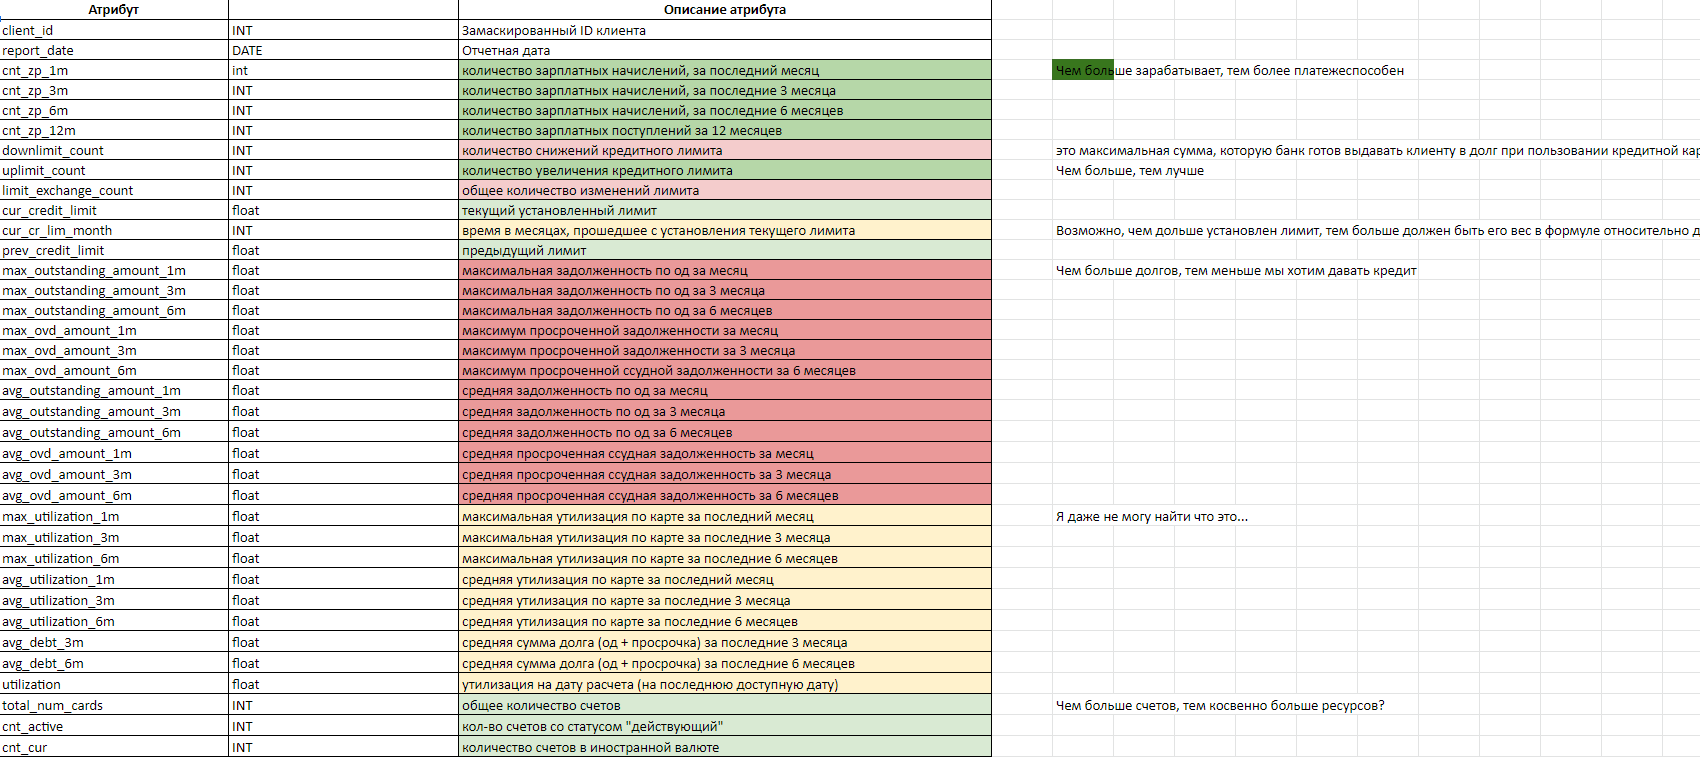

In [7]:
choice_columns = [3,7,34,40,48,55,70,71,76,91,92,93,100,101,103,104,105,107,110,114,115,116,117,118,126,133,153,163,184,200,217]

In [8]:
def columns_name(df,c_columns:list):
    return [df.columns[i] for i in c_columns]

assert columns_name(df,[0]) == ["client_id"]

In [9]:
w_df = df[columns_name(df,choice_columns)]
w_df.head()

,cnt_zp_3m,uplimit_count,cnt_active,num_credit_cards,cnt_dep_6m,max_term_50_5y_open,sum_acc_now,avg_sum_cls2op,sum_dep_income_1month,app_rel_status,app_real_estate_ind,app_vehicle_ind,app_total_job_experience_val,app_addresses_equal,app_client_category,app_cc_cnt,app_potreb_cnt,app_lst_request_m_term,sum_sal_acc_inc_6month_amt_rur,mrtg_open,cl_open,auto_open,card_open,micro_open,card_closed,length_bank,total_curr_payment,bki_loan_lst_close_m_term,age,avg_liab_sum_total_adv_agr,bank_60_89_5y_debtor
1601,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.236559,NaN,NaN
19147,17.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,0.0,Прочие физические лица,1.0,0.0,4.226,NaN,1.0,2.0,0.0,6.0,0.0,5.0,3.318275,27858.245845,9.002053,42.354839,0.0,0.0
19148,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,5.0,55.227926,0.000000,NaN,24.680108,0.0,0.0
19149,6.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,Никогда не состоял(а) в браке,0.0,1.0,124.0,0.0,Прочие физические лица,1.0,0.0,48.548,240513.51,1.0,0.0,0.0,0.0,0.0,3.0,57.790554,0.000000,1.675565,33.956989,21792.0,0.0
19150,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0,28.583162,0.000000,NaN,31.239247,0.0,0.0


Оценим разброс данных в таблице

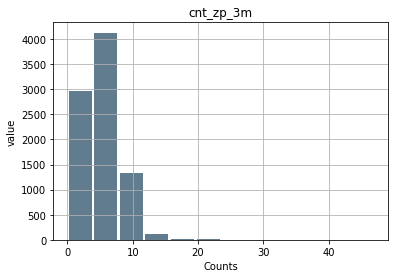

In [10]:
def show_column_data(df,column_name):
    s = df[column_name]
    s.plot.hist(grid=True, bins=12, rwidth=0.9,
                   color='#607c8e')
    plt.title(column_name)
    plt.xlabel('Counts')
    plt.ylabel('value')
show_column_data(df,"cnt_zp_3m")

видно, что за 3 месяца большинство людей получает зарплату 6-8 раз

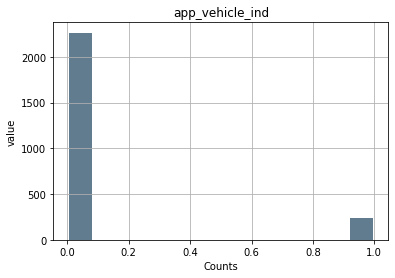

In [11]:
show_column_data(w_df,"app_vehicle_ind")

Из графика видно, что у большинства людей нет машины, однако, если использовать среднее арифметическое, то будет шум, который может повлиять на результаты

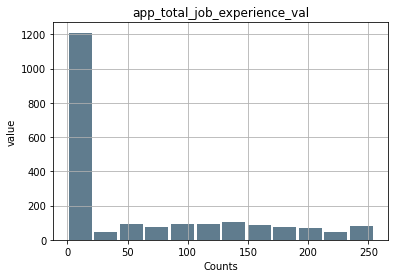

In [12]:
show_column_data(w_df,"app_total_job_experience_val")

в основном стаж работы 0, для этого параметра логично считать среднее арифметическое

In [13]:
w_df["app_total_job_experience_val"].fillna(w_df["app_total_job_experience_val"].mean(),inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


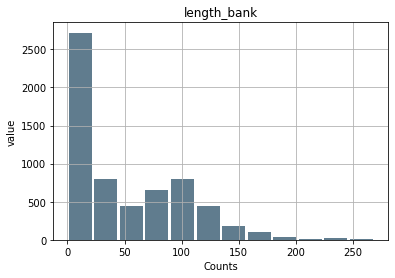

In [14]:
show_column_data(w_df,"length_bank")

По графику видно, что длительность кредитной истории клиента составляет до 5 лет.

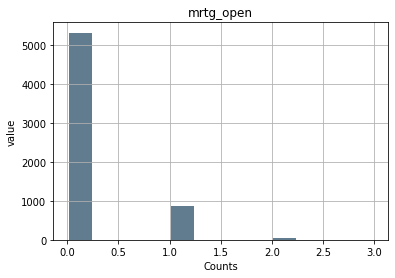

In [15]:
show_column_data(w_df,"mrtg_open")

Мы пришли к выводу, что выгодно использовать медиану для восстановления пропущенных данных

In [16]:
def nan2digit(df,flag = True):
    for col_name in df:
        column = df[col_name]
        if column.dtype != np.dtype("object"):
            if flag:
                mean_value = column.mean()
                df[col_name] = df[col_name].fillna(mean_value)
            else:
                median_value = column.median()
                df[col_name] = df[col_name].fillna(median_value) 
nan2digit(w_df,False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [17]:
def replace_rel_status(df):
  df.replace([" ","Никогда не состоял(а) в браке","Разведен(а) официально (развод зарегистрирован)","Вдовец (вдова)"],0,inplace = True)
  df.replace(["Состоит в зарегистрированном браке","Состоит в незарегистрированном браке"],1,inplace=True)
  df["app_rel_status"].fillna(0,inplace = True)
replace_rel_status(w_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [18]:
ord_enc = LabelEncoder()
def string_processing(df):
    for col_name in df:
        column = df[col_name]
        if column.dtype == np.dtype("object"):
            df["app_client_category"].fillna("Прочие физические лица",inplace=True)
            df[col_name] = ord_enc.fit_transform(df[col_name])
            print(col_name)
string_processing(w_df)

app_client_category


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Кроме того, мы думаем, что в некоторых случаях важно отследить динамику, посчитаем дополнительные параметры для наших данных.

In [19]:
def cash_flow(df,ind:list):
    """
        83 - 80 -> покажет превышают ли доходы клиента расходы по депозиту (за 3 месяца)
        84 - 85 -> аналогично, но за пол года
        первый индекс - доходы, второй - расходы
        Возвращает 0 если доходы меньше расходов 
        Возвращает 1 если доходы больше расходов
    """
    df_ = df[columns_name(df,ind)]
    nan2digit(df_)
    return df_[df_.columns[0]] > df_[df_.columns[1]]

cash_3_month = cash_flow(df,[80,83])
cash_6_month = cash_flow(df,[84,85])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [20]:
def check_cash_flow(df,indexes=[77,81,84,88]):
    """
        если 77>81>84>88, то пользователь копит деньги, возможно для крупной покупки
        возвращает 1, если 77 > 81 > 84  -> пользователь копит деньги
        иначе 0
    """
    df_ = df[columns_name(df,indexes)]
    nan2digit(df_)
    return [df_[df_.columns[0]] < df_[df_.columns[1]], df_[df_.columns[1]] < df_[df_.columns[2]]]
    
cash_flow_3and6_month = check_cash_flow(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [21]:
def check_load(df,indexes = [111,112,153]):
    """
    если (111 + 112)/5 > 153, то долговая нагрузка пользователя
    позволяет взять кредит 
    возвращает 1, если доходы позволяют взять кредит
    иначе 0
    """
    col_name = columns_name(df,indexes)
    df_ = df[col_name]
    nan2digit(df_)
    return (df_[col_name[0]] + df_[col_name[1]])/5 > df_[col_name[-1]]
user_cash_load = check_load(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [22]:
def mean_salary(df,indexes = [111,112]):
    col_name = columns_name(df,indexes)
    df_ = df[col_name]
    nan2digit(df_)
    return (df_[col_name[0]] + df_[col_name[1]])/2

user_mean_salary = mean_salary(df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [23]:
def previous_credit(df,indexes = [123,124,125,127]):
    """
    Рассмотрим склонен ли пользователь брать кредиты
    возвращает суммарное количество кредитов, которые брал пользователь
    """
    col_name = columns_name(df,indexes)
    df_ = df[col_name]
    nan2digit(df_,flag=False)
    return df_[col_name[0]] + df_[col_name[1]] + df_[col_name[2]] + df_[col_name[3]]
    
previous_user_credits = previous_credit(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [24]:
w_df["cash_3_month"] = cash_3_month.astype(int)
w_df["cash_6_month"] = cash_6_month.astype(int)
w_df["cash_flow_3_month"] = cash_flow_3and6_month[0].astype(int)
w_df["cash_flow_6_month"] = cash_flow_3and6_month[1].astype(int)
w_df["user_cash_load"] = user_cash_load.astype(int)
w_df["previous_user_credits"] = previous_user_credits
w_df["user_mean_salary"] = user_mean_salary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Посмотрим правильность работы функций

In [25]:
w_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9895 entries, 1601 to 152899
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cnt_zp_3m                       9895 non-null   float64
 1   uplimit_count                   9895 non-null   float64
 2   cnt_active                      9895 non-null   float64
 3   num_credit_cards                9895 non-null   float64
 4   cnt_dep_6m                      9895 non-null   float64
 5   max_term_50_5y_open             9895 non-null   float64
 6   sum_acc_now                     9895 non-null   float64
 7   avg_sum_cls2op                  9895 non-null   float64
 8   sum_dep_income_1month           9895 non-null   float64
 9   app_rel_status                  9895 non-null   float64
 10  app_real_estate_ind             9895 non-null   float64
 11  app_vehicle_ind                 9895 non-null   float64
 12  app_total_job_experience_val 

Для дальнейшей работы необходимо построить матрицу корреляции, чтобы уменьшить количество признаков сильно зависящих друг от друга

In [26]:
def show_coor_matrix(df):
  view_df = deepcopy(df)
  view_df.columns = [i for i in range(len(view_df.columns))]
  corr = view_df.corr()
  return corr.style.background_gradient(cmap='coolwarm').set_precision(1)


In [27]:
show_coor_matrix(w_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,1.0,0.1,0.2,0.2,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,-0.0,0.2,0.2,0.1,0.1,-0.0,0.1,0.1,0.1,0.0,0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.1,0.1,0.0
1,0.1,1.0,0.3,0.5,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.1,0.0,0.0,0.1,-0.0,0.2,0.3,0.1,0.1,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.1,0.1,0.0
2,0.2,0.3,1.0,0.6,0.1,0.0,-0.0,-0.0,0.0,0.1,0.1,0.1,-0.0,0.2,0.2,0.4,0.3,0.1,0.2,0.2,0.1,0.0,0.1,0.0,0.2,0.3,0.2,0.1,0.1,0.0,0.0,-0.1,-0.1,0.1,-0.0,-0.2,0.1,0.0
3,0.2,0.5,0.6,1.0,0.0,0.0,-0.0,0.0,0.0,0.2,0.2,0.2,-0.0,0.2,0.2,0.4,0.3,0.1,0.2,0.2,0.2,0.0,0.2,0.0,0.4,0.5,0.2,0.2,0.1,0.1,0.0,-0.0,-0.0,0.1,-0.0,-0.2,0.1,0.0
4,0.1,0.0,0.1,0.0,1.0,-0.0,0.0,0.0,0.2,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.1,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.1,0.0,-0.0,-0.2,-0.2,0.2,-0.0,-0.0,-0.0,0.0
5,0.0,0.0,0.0,0.0,-0.0,1.0,0.1,0.1,0.1,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.1,-0.0,0.0,0.0,0.0,-0.0,-0.1,-0.1,0.0,-0.1,0.0,-0.0,0.0
6,0.0,0.0,-0.0,-0.0,0.0,0.1,1.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
7,0.0,0.0,-0.0,0.0,0.0,0.1,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.1,0.1,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0
8,0.0,0.0,0.0,0.0,0.2,0.1,0.0,0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.1,-0.1,0.1,0.0,-0.0,-0.0,0.1
9,0.1,0.1,0.1,0.2,-0.0,0.0,-0.0,-0.0,0.0,1.0,0.3,0.3,0.4,0.3,0.2,-0.0,0.2,0.1,0.1,0.2,0.1,0.0,0.0,-0.0,0.1,0.2,0.1,0.1,0.0,0.1,0.0,-0.0,-0.0,0.0,-0.0,-0.1,0.1,0.1


Убрать mean salsry, cash_6_month

Выводы

*   Между столбцами (app_income_from_amt & avg_liab_sum_total_adv_agr) и (avg_liab_sum_total_adv_agr & cash_6_month), а также (app_real_estate_ind & app_vehicle_ind) есть корреляция
*   количество действующих счетов =+- количеству кредитных карт, среднее значение ЗП коррелирует с долговой нагрузкой, если происходит накопление денег, то и на 3 месяце ,и на 6ом месяце получи True



In [28]:
w_df.drop(columns=["num_credit_cards","cash_6_month","user_mean_salary"],inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
show_coor_matrix(w_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1.0,0.1,0.2,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,-0.0,0.2,0.2,0.1,0.1,-0.0,0.1,0.1,0.1,0.0,0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.0,-0.0,-0.0,0.0,-0.0,-0.1,0.1
1,0.1,1.0,0.3,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.1,0.0,0.0,0.1,-0.0,0.2,0.3,0.1,0.1,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.1,0.1
2,0.2,0.3,1.0,0.1,0.0,-0.0,-0.0,0.0,0.1,0.1,0.1,-0.0,0.2,0.2,0.4,0.3,0.1,0.2,0.2,0.1,0.0,0.1,0.0,0.2,0.3,0.2,0.1,0.1,0.0,0.0,-0.1,0.1,-0.0,-0.2,0.1
3,0.1,0.0,0.1,1.0,-0.0,0.0,0.0,0.2,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.1,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.1,0.0,-0.0,-0.2,0.2,-0.0,-0.0,-0.0
4,0.0,0.0,0.0,-0.0,1.0,0.1,0.1,0.1,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.1,-0.0,0.0,0.0,0.0,-0.0,-0.1,0.0,-0.1,0.0,-0.0
5,0.0,0.0,-0.0,0.0,0.1,1.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0
6,0.0,0.0,-0.0,0.0,0.1,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.1,0.1,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
7,0.0,0.0,0.0,0.2,0.1,0.0,0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.1,0.1,0.0,-0.0,-0.0
8,0.1,0.1,0.1,-0.0,0.0,-0.0,-0.0,0.0,1.0,0.3,0.3,0.4,0.3,0.2,-0.0,0.2,0.1,0.1,0.2,0.1,0.0,0.0,-0.0,0.1,0.2,0.1,0.1,0.0,0.1,0.0,-0.0,0.0,-0.0,-0.1,0.1
9,0.0,0.1,0.1,0.0,-0.0,0.0,-0.0,-0.0,0.3,1.0,0.6,0.1,0.1,0.1,0.1,0.0,0.1,0.1,0.1,-0.0,0.0,0.0,-0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0


Таким образом получили датасет без пропусков, в котором нет заметной корреляции между парметрами.Время использовать модели

In [30]:
from sklearn.cluster import KMeans
X = StandardScaler().fit_transform(w_df)
k_means = KMeans(n_clusters=2)
model = k_means.fit(X)
y_hat = k_means.predict(X)
y_hat.sum()

2106

In [31]:
x1 = StandardScaler().fit_transform(w_df[:5])
y = k_means.predict(x1)
y

array([0, 1, 0, 0, 0], dtype=int32)

In [32]:
w_df.head().T

,1601,19147,19148,19149,19150
cnt_zp_3m,6.000000,17.000000,0.000000,6.000000,6.000000
uplimit_count,1.000000,1.000000,1.000000,3.000000,1.000000
cnt_active,1.000000,2.000000,1.000000,1.000000,0.000000
cnt_dep_6m,0.000000,0.000000,0.000000,0.000000,0.000000
max_term_50_5y_open,6.935483,6.935483,6.935483,6.935483,6.935483
sum_acc_now,3.885000,3.885000,3.885000,3.885000,3.885000
avg_sum_cls2op,1.033907,1.033907,1.033907,1.033907,1.033907
sum_dep_income_1month,6564.040000,6564.040000,6564.040000,6564.040000,6564.040000
app_rel_status,0.000000,0.000000,0.000000,0.000000,0.000000
app_real_estate_ind,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
x1 = StandardScaler().fit_transform(w_df[10:15])
y = k_means.predict(x1)
y

array([0, 1, 0, 0, 1], dtype=int32)

In [34]:
w_df[10:15]

,cnt_zp_3m,uplimit_count,cnt_active,cnt_dep_6m,max_term_50_5y_open,sum_acc_now,avg_sum_cls2op,sum_dep_income_1month,app_rel_status,app_real_estate_ind,app_vehicle_ind,app_total_job_experience_val,app_addresses_equal,app_client_category,app_cc_cnt,app_potreb_cnt,app_lst_request_m_term,sum_sal_acc_inc_6month_amt_rur,mrtg_open,cl_open,auto_open,card_open,micro_open,card_closed,length_bank,total_curr_payment,bki_loan_lst_close_m_term,age,avg_liab_sum_total_adv_agr,bank_60_89_5y_debtor,cash_3_month,cash_flow_3_month,cash_flow_6_month,user_cash_load,previous_user_credits
19156,6.0,1.0,1.0,0.0,6.935483,3.885,1.033907,6564.04,0.0,0.0,0.0,56.920174,0.0,2,1.0,0.0,11.129,271959.375,0.0,0.0,0.0,1.0,0.0,0.0,2.135524,0.000000,25.166324,22.481183,0.000000,0.0,1,0,1,1,0.0
19157,7.0,1.0,2.0,4.0,1.322580,0.190,1.000000,0.19,0.0,0.0,0.0,56.920174,1.0,4,3.0,1.0,28.258,1297495.980,1.0,0.0,0.0,0.0,0.0,5.0,125.141684,5960.374013,84.533881,39.532258,0.000000,0.0,0,0,1,1,3.0
19158,8.0,1.0,2.0,0.0,6.935483,3.885,1.033907,6564.04,0.0,0.0,0.0,56.920174,0.0,2,2.0,0.0,12.516,271959.375,0.0,0.0,0.0,1.0,0.0,0.0,12.057495,499.950000,25.166324,54.607527,0.000000,0.0,1,0,1,1,0.0
19159,6.0,1.0,1.0,0.0,6.935483,3.885,1.033907,6564.04,0.0,0.0,0.0,56.920174,0.0,2,1.0,0.0,11.129,271959.375,0.0,0.0,0.0,1.0,0.0,1.0,32.229979,2766.121500,25.166324,30.196237,5774.333333,0.0,1,0,1,1,2.0
19160,7.0,1.0,2.0,0.0,6.935483,3.885,1.033907,6564.04,0.0,0.0,0.0,56.920174,1.0,4,3.0,4.0,15.129,475159.910,0.0,0.0,0.0,0.0,0.0,1.0,93.174538,0.000000,25.166324,49.806452,150000.000000,0.0,1,0,1,1,2.0


Выводы

*   Использовав алгоритм K ближайших соседей получили разбиние датасета на 2 категории.
*   С другой стороны видно, что разбиение происходит по нескольким столбцам

На основе тщательного анализа различных социальных исследований, а также официальных банковских отчетах оказалось, что наиболее часто потребительский кредит берут люди среднего возраста, со стажем работы около 5 лет, в браке. Именно по этим столбцам алгоритм разделил данные.
Попробуем определить, есть ли другие параметры, которые влияют на "склонность" к кредиту.





In [35]:
temp_df = w_df[["age","app_lst_request_m_term","app_total_job_experience_val","app_rel_status"]]
df_without_important_param = w_df.drop(columns=["age","app_lst_request_m_term","app_total_job_experience_val","app_rel_status"])


In [36]:
def koeff(person):
  temp=2
  if person["age"]<25.0 or person["age"]>50.0:
      temp*=0.5
  if person["app_lst_request_m_term"]<10:
      temp*=0.6
  if person["app_total_job_experience_val"]<60:
      temp*=0.9
  if person["app_rel_status"]==0:
      temp*=0.9

  if temp>=0.9:
      return 1
  return 0

temp_df["result"] = temp_df.apply(koeff, axis=1)
temp_df.head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,age,app_lst_request_m_term,app_total_job_experience_val,app_rel_status,result
1601,28.236559,11.129,56.920174,0.0,1
19147,42.354839,4.226,56.920174,0.0,1
19148,24.680108,11.129,56.920174,0.0,0
19149,33.956989,48.548,124.000000,0.0,1
19150,31.239247,11.129,56.920174,0.0,1
19151,30.301075,2.161,56.920174,0.0,1
19152,32.373656,3.258,56.920174,0.0,1
19153,22.188172,11.129,56.920174,0.0,0
19154,44.373656,2.548,20.000000,0.0,1
19155,18.432796,11.129,56.920174,0.0,0


Обучим дерево принятия решений. Этот алгоритм выбран, так как является наиболее наглядным, а логику его работы можно визуализировать, что очень удобно

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from sklearn.metrics import roc_auc_score
import graphviz 

y_real = temp_df["result"].to_numpy()*1
X = StandardScaler().fit_transform(df_without_important_param)
X_train,X_test, y_train,y_test = train_test_split(X,y_real, test_size=0.4,random_state = 0)

def best_tree_params():
  temp = 0
  for i in range(100):
    for j in range(5,20):
        dt = tree.DecisionTreeClassifier(max_depth=j,random_state=i)
        dt.fit(X_train, y_train)
        score = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
        if score > temp:
          print(f"max_depth = {j}, random state = {i}, score = {score}")
          temp = score
best_tree_params()
def best_reg_params():
  temp = 0
  for i in range(100):
    clf = LogisticRegression(random_state=i).fit(X_train, y_train)
    score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    if score > temp:
      print(f"random state = {i}, score = {score}")
      temp = score
best_reg_params()

max_depth = 5, random state = 0, score = 0.7172884574240479
max_depth = 5, random state = 2, score = 0.717924823491656
max_depth = 5, random state = 3, score = 0.7187562847667951
random state = 0, score = 0.7274077342747112


После того как нашли оптимальные параметры визуализируем работу алгоритма

In [40]:
dt = tree.DecisionTreeClassifier(max_depth=5,random_state=3)
dt.fit(X_train, y_train)
roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

0.7187562847667951

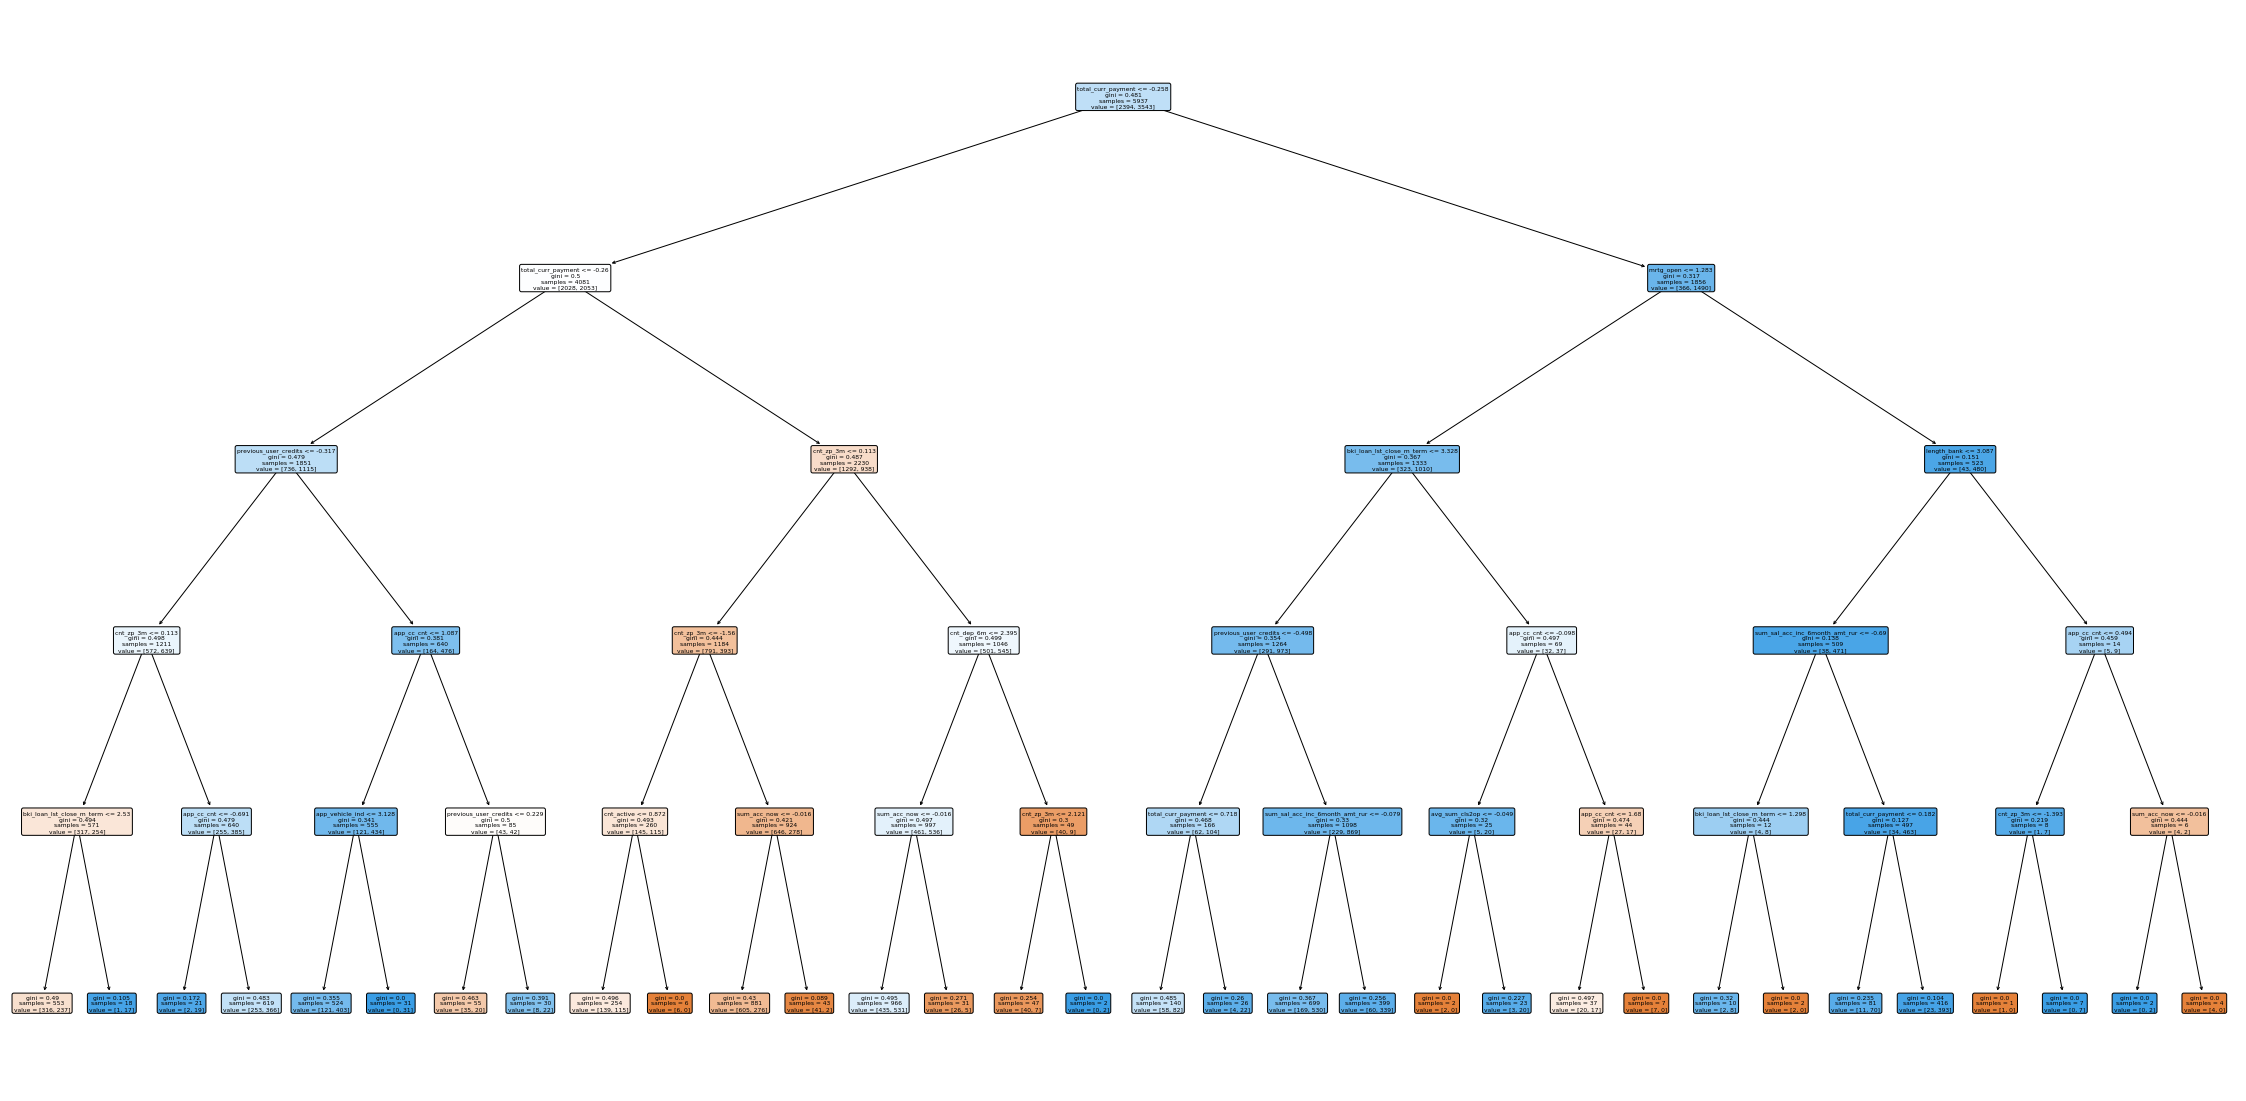

In [41]:
plt.figure(figsize=(40,20))  
_ = tree.plot_tree(dt, feature_names = df_without_important_param.columns, 
             filled=True, fontsize=6, rounded = True)
plt.show()

In [42]:
graph = Source( tree.export_graphviz(dt, out_file=None, feature_names = df_without_important_param.columns))
png_bytes = graph.pipe(format='png')
with open('dtree.png','wb') as f:
    f.write(png_bytes)


In [43]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.7274077342747112

найдены ключевые столбцы, по которым можно судить о склонности клиента к 

*   Восстановлены пропущенные данные
*   Построена матрица корреляции и удалены сильно коррелирующие параметры
*   С помощью алгоритма К ближайших соседей выявлены столбцы, по которым можно судить о склонности клиента к банковскому продукту
*   Натренированы классические модели машинного обучения, визуализирован алгоритм принятия решений.
